In [1]:
import dataiku
from dataiku import pandasutils as pdu

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import brier_score_loss
from sklearn.metrics import matthews_corrcoef

from sklearn.calibration import calibration_curve


Please import `spmatrix` from the `scipy.sparse` namespace; the `scipy.sparse.base` namespace is deprecated and will be removed in SciPy 2.0.0.
`scipy.optimize.linesearch.line_search_wolfe2` is deprecated along with the `scipy.optimize.linesearch` namespace. `scipy.optimize.linesearch.line_search_wolfe2` will be removed in SciPy 1.14.0, and the `scipy.optimize.linesearch` namespace will be removed in SciPy 2.0.0.
`scipy.optimize.linesearch.line_search_wolfe1` is deprecated along with the `scipy.optimize.linesearch` namespace. `scipy.optimize.linesearch.line_search_wolfe1` will be removed in SciPy 1.14.0, and the `scipy.optimize.linesearch` namespace will be removed in SciPy 2.0.0.


# Chargement des données

In [3]:
df = dataiku.Dataset("GUIDEPYTHONSOUSDATAIKU.titanic").get_dataframe()

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund; Mr, Owen Harris",male,"22,0",1,0,A/5 21171,"7,25",NaN,S
1,2,1,1,"Cumings; Mrs, John Bradley (Florence Briggs Th...",female,"38,0",1,0,PC 17599,"71,2833",C85,C
2,3,1,3,"Heikkinen; Miss, Laina",female,"26,0",0,0,"STON/O2, 3101282","7,925",NaN,S
3,4,1,1,"Futrelle; Mrs, Jacques Heath (Lily May Peel)",female,"35,0",1,0,113803,"53,1",C123,S
4,5,0,3,"Allen; Mr, William Henry",male,"35,0",0,0,373450,"8,05",NaN,S


# Sélection des colonnes

In [5]:
df.columns = df.columns.str.lower()

In [6]:
data = df.reset_index().rename(columns={"passengerid": "passenger_id"})  # passenger_id si absent

In [7]:
cols = ["passenger_id", "sex", "pclass", "age", "survived", "embarked"]

In [8]:
data = data.reset_index()[cols]

In [9]:
data.head()

,passenger_id,sex,pclass,age,survived,embarked
0,1,male,3,"22,0",0,S
1,2,female,1,"38,0",1,C
2,3,female,3,"26,0",1,S
3,4,female,1,"35,0",1,S
4,5,male,3,"35,0",0,S


In [10]:
data["pclass"] = data["pclass"].astype("object")   # ou .astype("category")

In [11]:
data["age"] = data["age"].astype(str).str.replace(",", ".", regex=False)
data["age"] = pd.to_numeric(data["age"], errors="coerce")

In [12]:
print(data.dtypes)

passenger_id      int64
sex              object
pclass           object
age             float64
survived          int64
embarked         object
dtype: object


In [13]:
data.head()

,passenger_id,sex,pclass,age,survived,embarked
0,1,male,3,22.0,0,S
1,2,female,1,38.0,1,C
2,3,female,3,26.0,1,S
3,4,female,1,35.0,1,S
4,5,male,3,35.0,0,S


In [14]:
data.describe()

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)


,passenger_id,age,survived
count,891.000000,714.000000,891.000000
mean,446.000000,29.699118,0.383838
std,257.353842,14.526497,0.486592
min,1.000000,0.420000,0.000000
25%,223.500000,20.125000,0.000000
50%,446.000000,28.000000,0.000000
75%,668.500000,38.000000,1.000000
max,891.000000,80.000000,1.000000


In [15]:
data.describe(include=['object', 'category'])

,sex,pclass,embarked
count,891,891,889
unique,2,3,3
top,male,3,S
freq,577,491,644


In [16]:
df['pclass'].value_counts(normalize=True) * 100

3    55.106622
1    24.242424
2    20.650954
Name: pclass, dtype: float64

In [17]:
df['sex'].value_counts(normalize=True) * 100

male      64.758698
female    35.241302
Name: sex, dtype: float64

In [18]:
df['embarked'].value_counts(normalize=True) * 100

S    72.440945
C    18.897638
Q     8.661417
Name: embarked, dtype: float64

# Variables explicatives et cible

In [19]:
X = data[["sex", "pclass", "embarked", "age"]]
y = data["survived"]

In [20]:
pclass_categories = [3, 1, 2]   # ordre: première modalité sera supprimée

In [21]:
sex_categories = ['male', 'female']

In [22]:
embarked_categories = ['S', 'C', 'Q']

# Pipelines de pré traitements

In [23]:
numeric_features = ["age"]
categorical_features = ["sex", "pclass", "embarked"]

In [24]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

In [25]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(categories=[sex_categories, pclass_categories, embarked_categories],
                             drop='first',  # supprime la première modalité de chaque variable -> référence
                             sparse=False,
                             dtype=float,
                             handle_unknown='error'))
])

In [26]:
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# Modèle

In [27]:
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("logistic", LogisticRegression(solver="lbfgs", max_iter=1000))
])

# Train du modèle

In [28]:
clf.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(categories=[['male',
                                                                                              'female'],
                                                                                             [3,
                                           

# Beta du modèle et grille de score

In [29]:
import numpy as np
import pandas as pd

def coef_table_with_references(pipeline, X, y, var_name_map=None, intercept_name='Intercept'):
    """
    Retourne DataFrame ['variable','modalite','beta','pop_pct','target_rate'] incluant la constante.
    - pipeline : Pipeline scikit-learn contenant 'preprocessor' (ColumnTransformer) et 'logistic' (estimator)
    - X : DataFrame d'entrée (mêmes colonnes et ordre que lors du fit)
    - y : Series/array binaire (0/1) aligné avec X
    - var_name_map : dict optionnel pour renommer variables
    - intercept_name : nom de la ligne intercept à ajouter
    Exigence : pipeline doit être fit.
    """
    X = X.reset_index(drop=True)
    y = pd.Series(y).reset_index(drop=True)
    n = len(X)

    pre = pipeline.named_steps['preprocessor']
    est = pipeline.named_steps['logistic']

    # récupérer coefficients (binaire) -> vecteur
    coefs = est.coef_
    if coefs.ndim > 1 and coefs.shape[0] == 1:
        coefs = coefs.ravel()
    elif coefs.ndim > 1:
        raise ValueError("Multi‑classe détectée : adapter la fonction pour choisir une classe ou moyenne.")

    intercept = float(est.intercept_[0]) if hasattr(est, 'intercept_') else 0.0

    rows = []
    coef_idx = 0
    input_features = list(X.columns)

    # helper pour stats par modalité sur DataFrame original
    def modal_stats(col, modal):
        if pd.isna(modal):
            mask = X[col].isna()
            label = np.nan
        else:
            mask = X[col] == modal
            label = modal
        cnt = int(mask.sum())
        pop_pct = float(cnt / n * 100) if n > 0 else float('nan')
        target_rate = float(y[mask].mean()) if cnt > 0 else float('nan')
        return cnt, pop_pct, target_rate, label

    for _, transformer, columns in pre.transformers_:
        if transformer == 'drop' or transformer is None:
            continue

        # normaliser liste de colonnes
        if isinstance(columns, (list, tuple)):
            cols = [c if isinstance(c, str) else input_features[c] for c in columns]
        elif isinstance(columns, slice):
            cols = input_features[columns]
        else:
            cols = [columns if isinstance(columns, str) else input_features[columns]]

        # inspecter dernier step si pipeline
        transformer_to_inspect = transformer
        if hasattr(transformer, 'named_steps'):
            transformer_to_inspect = list(transformer.named_steps.items())[-1][1]

        # OneHotEncoder: construire lignes pour modalités encodées et ajouter modalité de référence (beta=0)
        if hasattr(transformer_to_inspect, 'categories_'):
            cats_list = transformer_to_inspect.categories_
            drop = getattr(transformer_to_inspect, 'drop', None)

            for col_name, cats in zip(cols, cats_list):
                if drop == 'first':
                    used_cats = list(cats[1:])
                    dropped_cat = cats[0]
                    dropped_info = ('first', dropped_cat)
                elif isinstance(drop, (list, tuple, np.ndarray)):
                    try:
                        drop_val = drop[0] if len(drop) == 1 else drop[cols.index(col_name)]
                        used_cats = [c for c in cats if c != drop_val]
                        dropped_info = ('value', drop_val)
                    except Exception:
                        used_cats = list(cats)
                        dropped_info = (None, None)
                else:
                    used_cats = list(cats)
                    dropped_info = (None, None)

                for mod in used_cats:
                    if coef_idx >= len(coefs):
                        raise IndexError("Mismatch entre nombre de coefficients et colonnes encodées.")
                    cnt, pop_pct, target_rate, label = modal_stats(col_name, mod)
                    rows.append((col_name, str(label), float(coefs[coef_idx]), pop_pct, target_rate))
                    coef_idx += 1

                # ajouter la modalité de référence (celle supprimée) avec beta = 0 et stats réelles
                if dropped_info[0] is not None:
                    cnt, pop_pct, target_rate, label = modal_stats(col_name, dropped_info[1])
                    rows.append((col_name, str(label), 0.0, pop_pct, target_rate))

            continue

        # numériques / passthrough : une colonne par entrée
        for col in cols:
            if coef_idx >= len(coefs):
                raise IndexError("Mismatch entre nombre de coefficients et colonnes transformées.")
            # pour variables continues on met modalite='' et stats = NaN
            rows.append((col, '', float(coefs[coef_idx]), float('nan'), float('nan')))
            coef_idx += 1

    if coef_idx != len(coefs):
        raise ValueError(f"Nombre de coefficients utilisés ({coef_idx}) != longueur coefs ({len(coefs)}).")

    # construire DataFrame puis ajouter l'intercept comme dernière ligne (pop_pct et target_rate = NaN)
    df = pd.DataFrame(rows, columns=['variable', 'modalite', 'beta', 'pop_pct', 'target_rate'])
    df_intercept = pd.DataFrame([(intercept_name, '', intercept, float('nan'), float('nan'))],
                                columns=['variable','modalite','beta','pop_pct','target_rate'])
    df = pd.concat([df, df_intercept], ignore_index=True)

    if var_name_map:
        df['variable'] = df['variable'].map(lambda x: var_name_map.get(x, x))

    # tri lisible : variable puis modalite (les modalites vides ou numériques après)
    df = df.sort_values(by=['variable', 'modalite'], key=lambda s: s.fillna('')).reset_index(drop=True)

    return df


In [30]:
df_coefs = coef_table_with_references(pipeline=clf, X=X, y=y, var_name_map=None, intercept_name='Intercept')

In [31]:
df_coefs.style.format(
    {
        'pop_pct': lambda x: f"{x/100:,.2%}",
        'target_rate': lambda x: f"{x:,.2%}"
    }
)

,variable,modalite,beta,pop_pct,target_rate
0,Intercept,,-1.503364,nan%,nan%
1,age,,-0.030724,nan%,nan%
2,embarked,C,0.520479,18.86%,55.36%
3,embarked,Q,0.436438,8.64%,38.96%
4,embarked,S,0.000000,72.28%,33.70%
5,pclass,1,2.107316,24.24%,62.96%
6,pclass,2,1.199377,20.65%,47.28%
7,pclass,3,0.000000,55.11%,24.24%
8,sex,female,2.468813,35.24%,74.20%
9,sex,male,0.000000,64.76%,18.89%


# Probabilités

In [32]:
proba = clf.predict_proba(X)[:, 1]  # probabilité de la classe 1 (survie)

# Output

In [33]:
output = data.copy()

In [34]:
output["predicted_proba"] = np.round(proba, 8)

In [35]:
output = output[["passenger_id", "sex", "pclass", "age", "predicted_proba", "survived"]]
output = output.rename(columns={"survived": "real_outcome"})

In [36]:
output.head().style.format({'predicted_proba': lambda x: f"{x:,.2%}"})

,passenger_id,sex,pclass,age,predicted_proba,real_outcome
0,1,male,3,22.000000,10.16%,0
1,2,female,1,38.000000,91.88%,1
2,3,female,3,26.000000,54.16%,1
3,4,female,1,35.000000,88.05%,1
4,5,male,3,35.000000,7.05%,0


# Métriques de performances

In [37]:
y_true = output["real_outcome"].astype(int).values        # 0/1
y_score = output["predicted_proba"].astype(float).values  # probabilités [0,1]

## Mesures d'ordonancement du modèle

Ces mesures permettent de mesurer si le modèle classe les défaillants avec des probabilités plus élevées que les non défaillants, mais ne disent rien sur la valeur de la probabilité prédite en elle même.

### AUC et Gini

`configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`


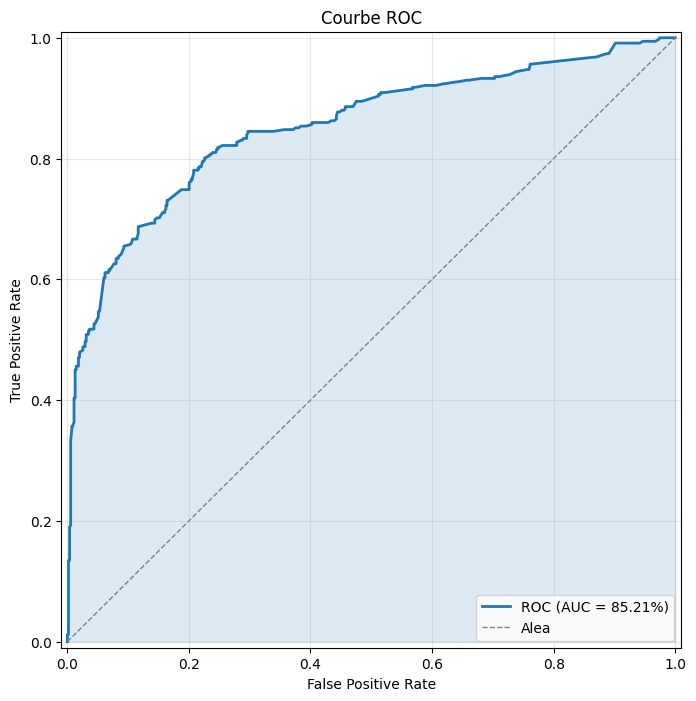

In [38]:
fpr, tpr, thresholds = roc_curve(y_true, y_score)

plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color="C0", lw=2, label=f"ROC (AUC = {roc_auc_score(y_true, y_score):.2%})")
plt.plot([0,1],[0,1], color="grey", lw=1, linestyle="--", label="Alea")
plt.fill_between(fpr, tpr, alpha=0.15, color="C0")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [39]:
auc = roc_auc_score(y_true, y_score)
print(f"AUC: {auc:.2%}")

AUC: 85.21%


L’AUC (ou AUC ROC) (Area Under the ROC Curve) mesure la capacité d’un score probabiliste à classer correctement un couple d’observations tirées aléatoirement, l’une positive et l’autre négative ; numériquement, c’est la probabilité que le modèle attribue un score plus élevé à la positive qu’à la négative.

L’AUC est indépendante du seuil de décision et résume la courbe ROC qui trace le taux de vrais positifs en fonction du taux de faux positifs pour tous les seuils.

Des seuils empirique d'AUC existent :
- 0.90–1.00 : Excellent — séparation très forte; rare pour problèmes difficiles.
- 0.80–0.90 : Très bon — bonne capacité discriminative pour la plupart des usages.
- 0.70–0.80 : Acceptable / Correct — utile mais améliorable, vérifier calibration et utilité métier.
- 0.60–0.70 : Faible — discrimination limitée; probablement insuffisant en production sans contraintes métier fortes.
- < 0.60 : Mauvais / proche du hasard — peu de valeur discriminative; reconsidérer features ou modèle.

Ces bornes sont des repères pratiques, pas des règles absolues ; l’interprétation dépend du contexte, du coût des erreurs et du déséquilibre des classes.

**Attention**, lorsque l'évènement mesuré est rare, il faut compléter l'analyse par une analyse de l'AUC PR car l'AUC ROC peut paraître élevé même si la précision sur les événements rares est faible.

De plus, l'analyse des mesures de calibration (Brier, reliability diagram, ECE) est necessaire car un bon AUC n'implique pas forcément que les probabilités soient correctement calibrées.

**Pour simplifier, une AUC de 84.78% veut dire que, si je prends 2 individus au hasard dans ma base, un positif et un négatif, j'ai 84.78% de chance que le score classe le positif comme plus risqué que le négatif.**

**Cela ne dit en rien si la probabilité calculée par le score est la bonne.**

In [40]:
gini = 2 * auc - 1
print(f"Gini: {gini:.2%}")

Gini: 70.42%


Le coefficient de Gini utilisé en scoring binaire mesure la capacité de discrimination d’un score en quantifiant l’inégalité entre la distribution des scores pour les positifs et les négatifs; il est essentiellement une transformation de l’AUC : Gini = 2 * AUC − 1, ce qui le relie directement à la probabilité qu’une observation positive soit mieux classée qu’une négative.

Dans l’usage courant (crédit, marketing), le Gini prend des valeurs proches de 0 pour un modèle sans pouvoir discriminant et proches de 1 pour un modèle parfait; des valeurs négatives indiquent un ordre inversé (le score favorise les négatifs) et signalent un grave problème de construction ou d’inversion des labels.

Des seuils empiriques existent :
- Gini ≥ 0.70 : Excellent — très forte séparation, rare sur des problèmes difficiles; approprié pour production critique.
- 0.60 ≤ Gini < 0.70 : Très bon — solide performance pour la plupart des usages industriels.
- 0.40 ≤ Gini < 0.60 : Correct / Acceptable — utile mais à compléter par contrôles opérationnels et calibration.
- 0.20 ≤ Gini < 0.40 : Faible — discrimination limitée; revoir features ou méthode.
- Gini < 0.20 : Mauvais — peu d’intérêt opérationnel, risque d’overfitting ou données non informatives.

Ces bornes sont des repères empiriques couramment adoptés en credit scoring.

**Attention**, Le Gini évalue la discrimination (ordre des scores) mais ne renseigne pas sur la calibration des probabilités; il faut donc l’accompagner de métriques de calibration (Brier, ECE).

En présence de classes très déséquilibrées, compléter par AUC PR.

### AUC PR et ratio de performances

In [41]:
precision, recall, thresholds = precision_recall_curve(y_true, y_score)

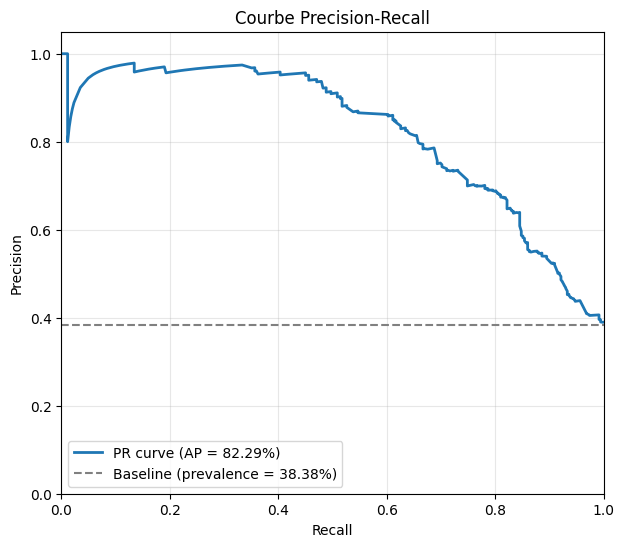

In [42]:
plt.figure(figsize=(7,6))
plt.plot(recall, precision, color="C0", lw=2, label=f"PR curve (AP = {average_precision_score(y_true, y_score):.2%})")
plt.hlines(y_true.mean(), 0, 1, colors="grey", linestyles="--", label=f"Baseline (prevalence = {y_true.mean():.2%})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe Precision-Recall")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()

In [43]:
auc_pr = average_precision_score(y_true, y_score)
print(f"AUC PR: {auc_pr:.2%}")

AUC PR: 82.29%


L’AUC‑PR (ou Average Precision) résume la courbe Precision–Recall en une seule valeur entre 0 et 1 et mesure la capacité d’un score à produire des prédictions avec à la fois une bonne précision et un bon rappel; **elle est particulièrement appropriée quand la classe positive est rare.**

La valeur de référence (baseline) d’une courbe PR correspond à la prévalence empirique de la classe positive dans les données; une courbe PR qui coïncide avec cette ligne signifie qu’un classifieur aléatoire atteindrait la même précision moyenne, donc l’Average Precision doit être comparée à la prévalence pour juger de l’amélioration effective.

Quand la prévalence est faible, la ligne de base est basse et une petite augmentation absolue de l’AP peut représenter un gain relatif important pour la détection des positifs. Inversement, pour une prévalence élevée, une AP élevée est plus facile à obtenir et l’interprétation doit tenir compte du contexte métier et des coûts d’erreur.

**Il n'existe pas de seuils empiriques relatifs à l'AUC PR, car les valeus dépendent de la valeur de baseline.**
Pour cela, on utilise le ratio de performance.

In [44]:
prevalence = y_true.mean()
performance_ratio = auc_pr / prevalence if prevalence > 0 else np.nan
print(f"Ratio de performance: {performance_ratio:.2f}")

Ratio de performance: 2.14


Le **ratio de performance mesure combien de fois la performance moyenne en précision du modèle dépasse la précision moyenne attendue en tirant au hasard des observations positives selon la prévalence**. Ce ratio met en évidence le gain relatif apporté par le score quand la prévalence est faible.

En effet, l'AUC PR peut sembler petite si la prévalence est très faible, cela même si le modèle est bien meilleur que la baselinbe.

Des seuils empiriques peuvent exister : 
- ratio ≈ 1 : pas d’amélioration par rapport à la prévalence.
- ratio entre 1.5 et 3 : amélioration utile selon le contexte opérationnel.
- ratio > 3 : souvent considéré comme un fort gain relatif pour des actions ciblées.

Ces bornes sont des repères empiriques dépendant du domaine et du coût des actions. Un ratio élevé peut tout de même cacher une AUCPR faible en valeur absolue si la prévalence est extrêmement basse, d’où la nécessité d'analyser AUCROC et AUCPR conjointement.

**Pour simplifier, un ratio de performance de 2 indique que votre modèle identifie en moyenne 2 fois plus de vrais positifs que le hasard parmi les individus classés en positifs (précision du modèle).**

## Mesures de calibration du modèle

Ces mesures donnent la précision des probabilités calculées, mais ne disent rien sur l'ordonancement du modèle

### Courbe de calibration des probabilités

In [45]:
def reliability_diagram(y_true, y_score, n_bins=20):
    
    prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=n_bins)

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True, constrained_layout=True)
    
    ax1.plot(prob_pred, prob_true, marker='o', linewidth=2, label=f"Model (Brier={brier_score_loss(y_true, y_score):.2%})")
    ax1.plot([0,1],[0,1], linestyle='--', color='gray', label='Perfect calibration')
    ax1.set_xlabel("Mean predicted probability")
    ax1.set_ylabel("Fraction of positives")
    ax1.set_title("Reliability diagram (calibration curve)")
    ax1.legend(loc="best")
    ax1.grid(alpha=0.3)
    
    ax2.hist(y_score, bins=n_bins, color='C0', edgecolor='k', alpha=0.7)
    ax2.set_xlabel("Predicted probability")
    ax2.set_ylabel("Count")
    ax2.set_title("Histogram of predicted probabilities")
    ax2.grid(alpha=0.2)
    
    N = len(y_score) if len(y_score) > 0 else 1
    ax_perc = ax2.twinx()

    primary_yticks = ax2.get_yticks()
    secondary_yticks = primary_yticks / N 

    ax_perc.set_yticks(primary_yticks)  # positionner aux mêmes valeurs numériques que l'axe gauche
    ax_perc.set_ylim(ax2.get_ylim())  # garder mêmes limites pour alignement visuel
    ax_perc.set_ylabel("Share of total (%)")
    ax_perc.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{100.0 * (y / N):.0f}%"))
    
    plt.show()

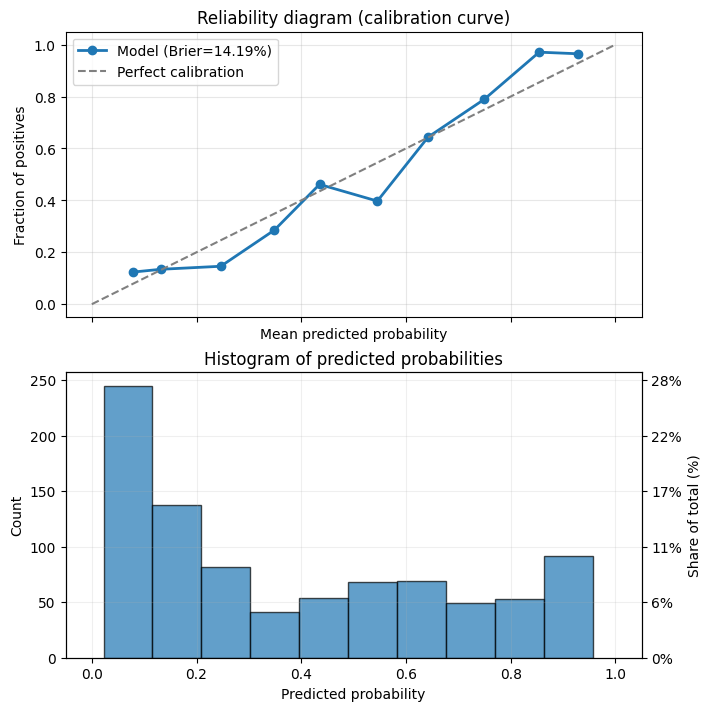

In [46]:
reliability_diagram(y_true, y_score, n_bins=10)

Le reliability diagram (ou calibration curve) compare, pour des groupes de prédictions de même probabilité prédite, la moyenne des probabilités prédites à la fraction observée d’événements dans chaque groupe, et permet de vérifier si, par exemple, les instances prédites à 0.70 aboutissent ~70% du temps à l’événement observé.

Interprétation :
- Si la courbe suit la diagonale y = x : parfaitement calibré (p_pred = fréquence observée).
- Si la courbe est au‑dessus de la diagonale : le modèle sous‑estime le risque (les événements sont plus fréquents que prévu pour ces p_pred).
- Si la courbe est en dessous de la diagonale : le modèle sur‑estime le risque (les événements sont moins fréquents que prévu pour ces p_pred)

Le nombre de bins a un impact fort sur la courbe de calibration. Des bins trop larges masquent des défauts locaux, des bins trop fins donnent du bruit quand peu d’événements sont présents dans chaque bin. D'où l'interet d'afficher la population par beans.

**L'indicateur ECE (Expected Calibration Error) permet d'apporter une valeur sur la courbe observée, comme l'AUC-ROC pour la courbe ROC.**

**La décomposition de Brier permet de mesurer si l'erreur vient d'un mauvais calibrage (reliability) ou d'un manque de pouvoir discriminant (resolution).**

### Brier Score, BSS

In [47]:
brier = brier_score_loss(y_true, y_score)   # (valeur moyenne de (p - o)^2)
print(f"Brier score: {brier:.2%}")

Brier score: 14.19%


Le Brier score mesure l’erreur moyenne quadratique entre les probabilités prédites et les événements observés pour des issues binaires. C'est l'équivalent à l’erreur quadratique moyenne appliquée aux modèles de probabilités.

Le Brier varie entre 0 (prévisions parfaites) et 1 (pire possible pour probabilités bornées). **Un Brier plus faible signifie de meilleures probabilités prédites au sens de la moyenne quadratique**. 

**Le Brier permet de mesurer à quelle point les probabilités calibrées sont précises, mais ne dit rien sur l'ordonnancement de ces probabilités, d'où l'analyse necessaire de l'AUC ROC et PR.**

Comme pour l'erreur quadratique moyenne, il n'existe pas de seuil de performance usuel. On utilise donc le BSS.

In [48]:
prev = y_true.mean()                      # fréquence empirique de l'événement
brier_clim = brier_score_loss(y_true, np.full_like(y_score, prev))
bss = 1.0 - (brier / brier_clim) if brier_clim > 0 else np.nan
print(f"Prevalence : {prev:.2%}")
print(f"Brier : {brier:.2%}")
print(f"Brier Skill Score (BSS): {bss:.2%}")

Prevalence : 38.38%
Brier : 14.19%
Brier Skill Score (BSS): 40.02%


Le Brier Skill Score est une métrique développée en météorologie. Il compare le Brier score du modèle avec le brier score d'un modèle de référence, typiquement le modèle aléatoire.

**Un BSS positif indique que le modèle améliore la référence, 0 signifie aucune amélioration, et un BSS négatif indique une performance pire que la référence**

### Décomposition de Brier

In [49]:
def brier_decomposition(y_true, y_prob, n_bins=10, strategy='uniform'):

    y_true = np.asarray(y_true, dtype=int)
    y_prob = np.asarray(y_prob, dtype=float)
    N = len(y_true)
    if N == 0:
        raise ValueError("Empty input.")
    # Brier score
    brier = np.mean((y_prob - y_true) ** 2)
    # global prevalence
    o_bar = y_true.mean()

    # bin edges
    if strategy == 'quantile':
        edges = np.unique(np.quantile(y_prob, np.linspace(0, 1, n_bins + 1)))
        if len(edges) - 1 < n_bins:
            # fallback to uniform if too few distinct edges
            edges = np.linspace(0.0, 1.0, n_bins + 1)
    else:
        edges = np.linspace(0.0, 1.0, n_bins + 1)

    # assign bins (rightmost bin includes 1.0)
    bin_idx = np.digitize(y_prob, edges, right=True) - 1
    bin_idx = np.clip(bin_idx, 0, len(edges) - 2)

    # aggregate per bin
    df = pd.DataFrame({'y': y_true, 'p': y_prob, 'bin': bin_idx})
    agg = df.groupby('bin').agg(n=('y','size'), p_mean=('p','mean'), o_mean=('y','mean')).reset_index()

    # compute components
    reliability = ((agg['n'] * (agg['p_mean'] - agg['o_mean'])**2).sum()) / N
    resolution = ((agg['n'] * (agg['o_mean'] - o_bar)**2).sum()) / N
    uncertainty = o_bar * (1.0 - o_bar)

    return {
        'brier': float(brier),
        'reliability': float(reliability),
        'resolution': float(resolution),
        'uncertainty': float(uncertainty),
        'brier_decomposed': float(reliability - resolution + uncertainty),
#         'agg_bins': agg,
#         'o_bar': float(o_bar),
#         'edges': edges
    }

In [50]:
decomp_results = brier_decomposition(y_true, y_score, n_bins=10)
print(f"Brier = {decomp_results['brier']:.2%}")
print(f"reliability = {decomp_results['reliability']:.2%}")      
print(f"resolution = {decomp_results['resolution']:.2%}")      
print(f"uncertainty = {decomp_results['uncertainty']:.2%}")
      
# Brier = Reliability − Resolution + Uncertainty

Brier = 14.19%
reliability = 0.47%
resolution = 9.80%
uncertainty = 23.65%


La **Reliability** permet de mesurer à quel point les probabilités prédites sont bien calibrées.
- Une reliability faible signifie que, en moyenne, les prédictions sont proches des fréquences observées.
- Une reliability élevée indique un mauvais calibrage : les probabilités prédites diffèrent systématiquement des fréquences réelles, ce qui se traduit par une perte de score.
- Intuitivement, c'est le cout lié aux erreurs systématiques dans l'échelle des probabilités

La **résolution** mesure la capacité du modèle à séparer la population en groupes de risques réellement différents. Concrètement, elle regarde combien les fréquences observées par bin s’éloignent de la prévalence globale. 
- Une haute resolution signifie que le modèle crée des groupes où certains ont nettement plus d’événements que la moyenne et d’autres nettement moins ; c’est utile pour la prise de décision ciblée.
- Une faible resolution signifie que, même si le modèle peut être bien calibré, il ne différencie pas beaucoup les individus ; il n’apporte donc pas d’information discriminante.
- Intuitivement, c’est la valeur informative du modèle, sa capacité à distinguer les risques.

L'**uncertainty** est la variance intrinsèque du phénomène à prévoir. Elle représente la part d’erreur que l’on ne peut pas réduire par le modèle parce que le problème lui‑même est incertain.

Dans notre cas, nous avons :
- une faible Reliability, preuve que le modèle calibre bien ces probabilités ;
- une bonne résolution, preuve que le modèle segmente bien lorsque découpé avec ces classes là ;
- une uncertainty élevée, preuve que le problème est intrinsèquement complexe avec du bruit de fond inéluctable

### ECE

In [51]:
def compute_ece(df, proba_col="predicted_proba", target_col="real_outcome", n_bins=15):
    df_local = df[[proba_col, target_col]].dropna().copy()
    probs = df_local[proba_col].astype(float).values
    labels = df_local[target_col].astype(int).values
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(probs, bins, right=False) - 1
    bin_ids = np.clip(bin_ids, 0, n_bins - 1)
    ece = 0.0
    bin_info = []
    N = len(probs)
    for b in range(n_bins):
        mask = bin_ids == b
        n_b = mask.sum()
        if n_b == 0:
            bin_info.append({"bin": b, "count": 0, "mean_pred": np.nan, "frac_pos": np.nan, "abs_gap": np.nan})
            continue
        mean_pred = probs[mask].mean()
        frac_pos = labels[mask].mean()
        abs_gap = abs(mean_pred - frac_pos)
        ece += (n_b / N) * abs_gap
        bin_info.append({"bin": b, "count": int(n_b), "mean_pred": float(mean_pred), "frac_pos": float(frac_pos), "abs_gap": float(abs_gap)})
    return {"ece": float(ece), "n_bins": n_bins, "bin_info": pd.DataFrame(bin_info)}

In [52]:
ece_value = compute_ece(output, n_bins=10)["ece"]
print(f"ECE: {ece_value:.2%}")

ECE: 5.12%


L’Expected Calibration Error ou ECE est une métrique simple qui résume à quel point les probabilités prédites par un modèle sont alignées avec les fréquences observées. Elle donne une moyenne pondérée des écarts absolus entre probabilité prédite et fréquence observée sur des groupes de prédictions.

On regroupe les prédictions en K bins par valeur prédite (bins à largeur égale ou quantiles). Pour chaque bin k on calcule p̄_k la probabilité prédite moyenne et ō_k la fréquence observée d’événements. L’ECE est la moyenne des écarts absolus pondérés par la taille des bins.

$$\mathrm{ECE} \;=\; \sum_{k=1}^{K} \frac{n_k}{N}\; |\,p̄_k-ō_k|$$
avec n_k l'effectif du bin k et N le nombre total d'observation

Plus l'ECE est poche de 0, meilleure est la calibration.
Un ECE de 2% signifie qu'en moyenne, les probabilités sont décalées de 2 points absolus par rapport à la réalité.

Avec une faible prévalence et peu d’exemples, l’ECE peut être instable.

## Résumé

In [53]:
metrics = pd.DataFrame({
    "metric": ["AUC", "Gini", "prevalence", "AUC PR", "performance_ratio", "Brier", "BSS", "ECE"],
    "value": [auc, gini, prevalence, auc_pr, performance_ratio, brier, bss, ece_value]
})

In [54]:
metrics

,metric,value
0,AUC,0.852094
1,Gini,0.704188
2,prevalence,0.383838
3,AUC PR,0.822943
4,performance_ratio,2.143982
5,Brier,0.141862
6,BSS,0.400179
7,ECE,0.051239
